# KNN control using the reservoir to model the system

In [3]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

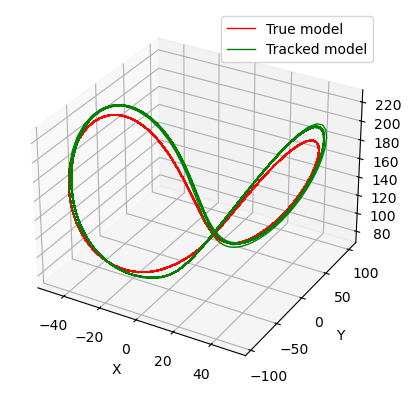

In [2]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

## PI control parameters
Kp = 1
Ki = 0.5

## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    f[:, t] = np.array([x, y, z])

## Finding Wout matrix using ridge regression
f = f[:, -10000:] 
R = R[:, -10000:]
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  


### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest)             
ypid = np.zeros(ntest)
zpid = np.zeros(ntest)

## For storing error time series data
err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxpid, yypid, zzpid = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system
    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## Actual system
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + 1)

    xpid[t] = xtrack
    ypid[t] = ytrack
    zpid[t] = ztrack



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 1, label = 'True model')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()



While doing control, find the error between the real system and the reservoir-target model and also the error between the real system and the ideal model, to see how bad the control input is because of using the reservoir as the model. This would help in the cases where the real system is somewhere in between the ideal and the predicted target, then because the prediction is pulling the system towards it instead of the ideal trajectory, we see the possibility of the system actually being pulled away from ideal. I suspect, if the disturbance is high, it's actually good, because the predicted model is "good enough" to crudely pull the system closer. But when the disturbance pushes the trajectory by a distance that is comparable to the range of the error between the reservoir predicted model and the ideal trajectory, then the pid control would fail worse than when there is no control since the controller is pulling the trajectory into a trajectory that is further away from the ideal trajectory.

### 25 Jan ###

Need to make the forecasting as good as possible. To try: Add noise (maybe gaussian) to the trajectory, so that the model learns to go back to the orbit, even if there is noise? Two ways to do this: one is, add noise during training itself, so the actual trajectory data is noisy. Other way, take the data with no noise, and then add a gaussian noise to the trajectory data.

Need to think about what happens during control: should the reservoir model just be predicting on its own(so just give initial state, the reservoir is just running on its own giving a predicted trajectory for each instant) or should the prediction use the current state? What if, when training, I collect the data, and then use that itself as the refeence trajectory? So I'm at a different point now, I just find the shortest distance between this point and the trajectory, and then find control input as K times (this error). Even for the nearest point, I could just use the nearest point found from previous instant, and search close to it. Can this be done for forecasting as well? Just go to the data, choose the closest point to the current point and that's the forecast? In a way, a reservoir model should probably take up lesser memory? Because it's more of a parametric model. Whereas the other, just finding the closest point and working with it seems like KNN which is non-parametric. 

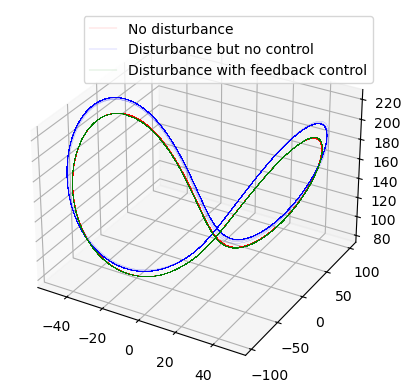

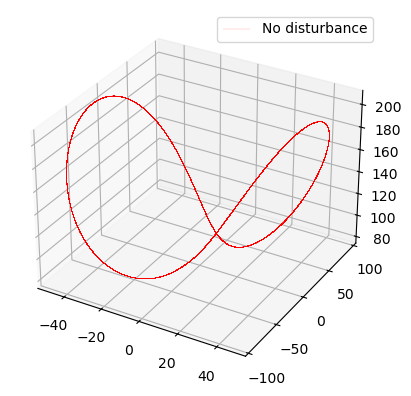

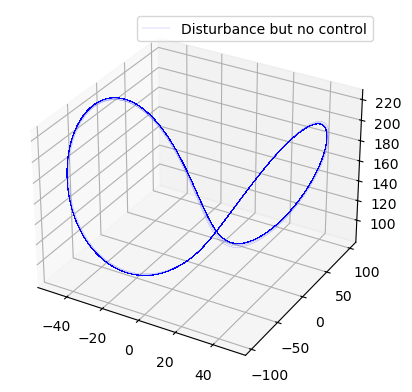

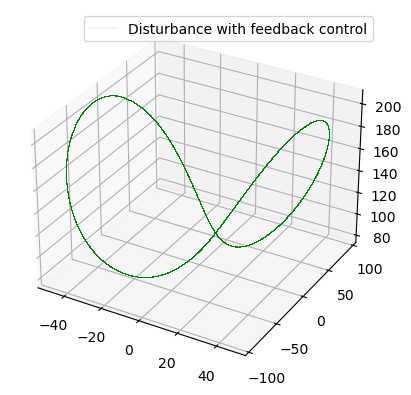

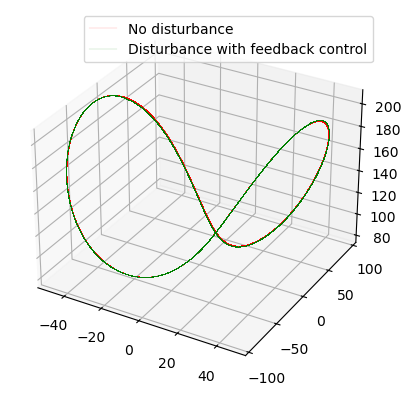

In [23]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

### Collecting training data

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    f[:, t] = np.array([x, y, z])

f = f[:, -10000:]

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
controlgain = 1.5
disfac = 10

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)


## For storing x, y, z time series data of actual system
xknn = np.zeros(ntest)             
yknn = np.zeros(ntest)
zknn = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxknn, yyknn, zzknn = x, y, z

## Time evolution

for t in range(ntest):
    
    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol


    ## Actual system with KNN control
    
    ### xxknn, yyknn, zzknn contain the current state of the system
    ### Searching for the nearest neighbour in the training data
    ### The control input is some control gain times the difference between the current state 
    ### and the state of the nearest neighbour

    ## Finding the nearest neighbour in the training data
    dist = norm(f.T - np.array([xxknn, yyknn, zzknn]), axis = 1)
    idx = np.argmin(dist)
    xref, yref, zref = f[:, idx]

    xxknnp = sigma * (yyknn - xxknn)
    yyknnp = xxknn * (rho - zzknn) - yyknn + disfac * xxknn
    zzknnp = xxknn * yyknn - beta * zzknn

    xxknn += dt * xxknnp + controlgain * (xref - xxknn)
    yyknn += dt * yyknnp + controlgain * (yref - yyknn)
    zzknn += dt * zzknnp + controlgain * (zref - zzknn)

    xknn[t] = xxknn
    yknn[t] = yyknn
    zknn[t] = zzknn


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()


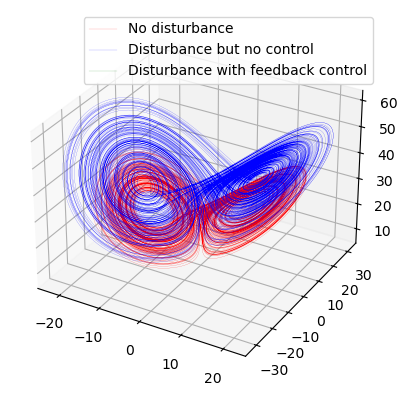

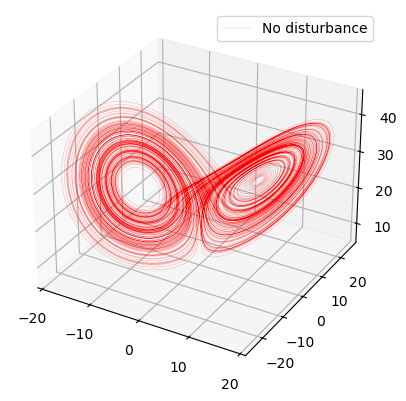

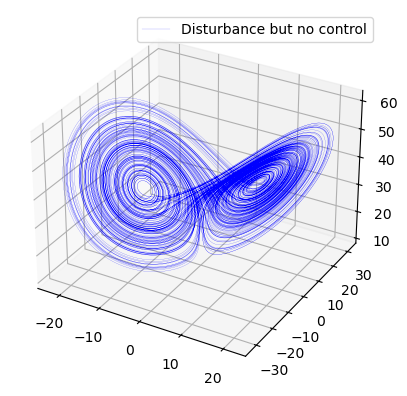

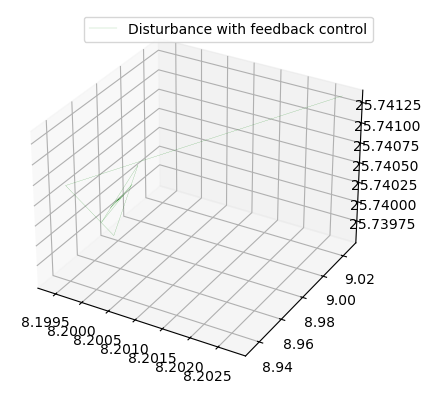

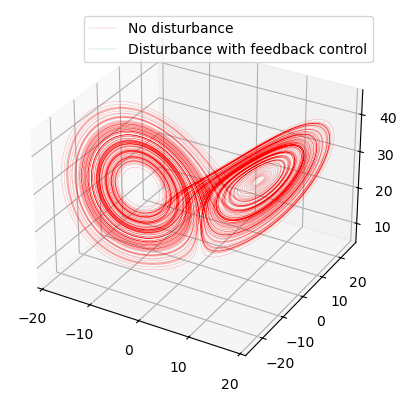

In [24]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)

### Collecting training data

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
f = np.zeros((m, ntraining))

## Collecting reservoir time-series data
for t in range(ntraining):

    xp = sigma * (y - x)
    yp = x * (rho - z) - y 
    zp = x * y - beta * z

    x += dt * xp
    y += dt * yp
    z += dt * zp

    f[:, t] = np.array([x, y, z])

f = f[:, -10000:]

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
controlgain = 1.5
disfac = 10

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)


## For storing x, y, z time series data of actual system
xknn = np.zeros(ntest)             
yknn = np.zeros(ntest)
zknn = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxknn, yyknn, zzknn = x, y, z

## Time evolution

for t in range(ntest):
    
    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol


    ## Actual system with KNN control
    
    ### xxknn, yyknn, zzknn contain the current state of the system
    ### Searching for the nearest neighbour in the training data
    ### The control input is some control gain times the difference between the current state 
    ### and the state of the nearest neighbour

    ## Finding the nearest neighbour in the training data
    dist = norm(f.T - np.array([xxknn, yyknn, zzknn]), axis = 1)
    idx = np.argmin(dist)
    xref, yref, zref = f[:, idx]

    xxknnp = sigma * (yyknn - xxknn)
    yyknnp = xxknn * (rho - zzknn) - yyknn + disfac * xxknn
    zzknnp = xxknn * yyknn - beta * zzknn

    xxknn += dt * xxknnp + controlgain * (xref - xxknn)
    yyknn += dt * yyknnp + controlgain * (yref - yyknn)
    zzknn += dt * zzknnp + controlgain * (zref - zzknn)

    xknn[t] = xxknn
    yknn[t] = yyknn
    zknn[t] = zzknn


plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()

plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'No disturbance')
ax.plot3D(xknn, yknn, zknn, 'g', linewidth = 0.1, label = 'Disturbance with feedback control')
plt.legend()
plt.show()


So clearly, this works only for periodic orbits. For chaotic orbits, this fails miserably. I'm not sure why.